In [1]:
!pip install git+https://github.com/rtqichen/torchdiffeq

  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-y898k9yy
  Running command git clone --filter=blob:none --quiet https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-y898k9yy
  Resolved https://github.com/rtqichen/torchdiffeq to commit 8df757cb12f231a6b4349a96608b7a9d11166988
  Preparing metadata (setup.py) ... - done
  Created wheel for torchdiffeq: filename=torchdiffeq-0.2.3-py3-none-any.whl size=31200 sha256=36c3be86ecd6283f40e313b0f97f55cc0872d97be6af3451c1126d659e3e465d
  Stored in directory: /tmp/pip-ephem-wheel-cache-kgaejlrq/wheels/42/b5/d4/aeb3622995bff5e90fcc0c0ef799a6951e48daaf17e293281e
Successfully built torchdiffeq


In [2]:
import numpy as np
import scipy.io
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from IPython.display import display, clear_output
gpu = '0'
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [3]:
block_size = 400
freq = 100
scaled = False

In [4]:
train_mat = scipy.io.loadmat('../input/ae-test-train10/S_latent_train_10.mat')
test_mat  = scipy.io.loadmat('../input/ae-test-train10/S_latent_test_10.mat')
train_set = torch.tensor(train_mat['S'])
test_set = torch.tensor(test_mat['S'])
train_len = train_set.shape[0]
test_len = test_set.shape[0]

In [5]:
train_set.shape, test_set.shape

(torch.Size([4000, 2]), torch.Size([3600, 2]))

In [6]:
scaling = train_set.max() if scaled else 1
train_set_ = torch.unsqueeze(train_set,1)/scaling
test_set_ = torch.unsqueeze(test_set,1)/scaling
train_set_.shape, test_set_.shape

(torch.Size([4000, 1, 2]), torch.Size([3600, 1, 2]))

In [7]:
n_params_train = 10
n_params_test = 9
params_ = torch.linspace(5e-3,5e-2,n_params_train).unsqueeze(1)
params_test_ = torch.stack([(params_[i]+params_[i+1])/2 for i in range(n_params_test)])

params_blocked = torch.stack([params_[i,:] for i in range(n_params_train) for j in range(block_size)])
params_blocked_test = torch.stack([params_test_[i,:] for i in range(n_params_test) for j in range(block_size)])

params_blocked = params_blocked.unsqueeze(1)
params_blocked_test = params_blocked_test.unsqueeze(1)

params_blocked.shape, params_blocked_test.shape

train_set = torch.cat([train_set_, params_blocked],-1)
test_set = torch.cat([test_set_, params_blocked_test],-1)

train_set.shape, test_set.shape

(torch.Size([4000, 1, 3]), torch.Size([3600, 1, 3]))

In [8]:
def get_data(batch_time=block_size,dataset_type='train',time_extrapolate=False,extrapolationT=400):
    
    if dataset_type == 'train':
        dataset_len = train_len
        dataset = train_set
        dataset_ = train_set_
        batch_size = n_params_train
    if dataset_type == 'test':
        dataset_len = test_len
        dataset = test_set
        dataset_ = test_set_
        batch_size = n_params_test
    
    batch_t = torch.arange(extrapolationT).float() if time_extrapolate else torch.arange(batch_time).float()
    start_idx = torch.arange(0,dataset_len,block_size)
    s = torch.from_numpy(np.random.choice(np.arange(block_size-batch_time+1), batch_size, replace=True))
    s = start_idx + s
    batch_u0 = dataset[s,:,:].float()
    batch_u = torch.stack([dataset_[s+i,:,:] for i in range(batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), s.to(device)

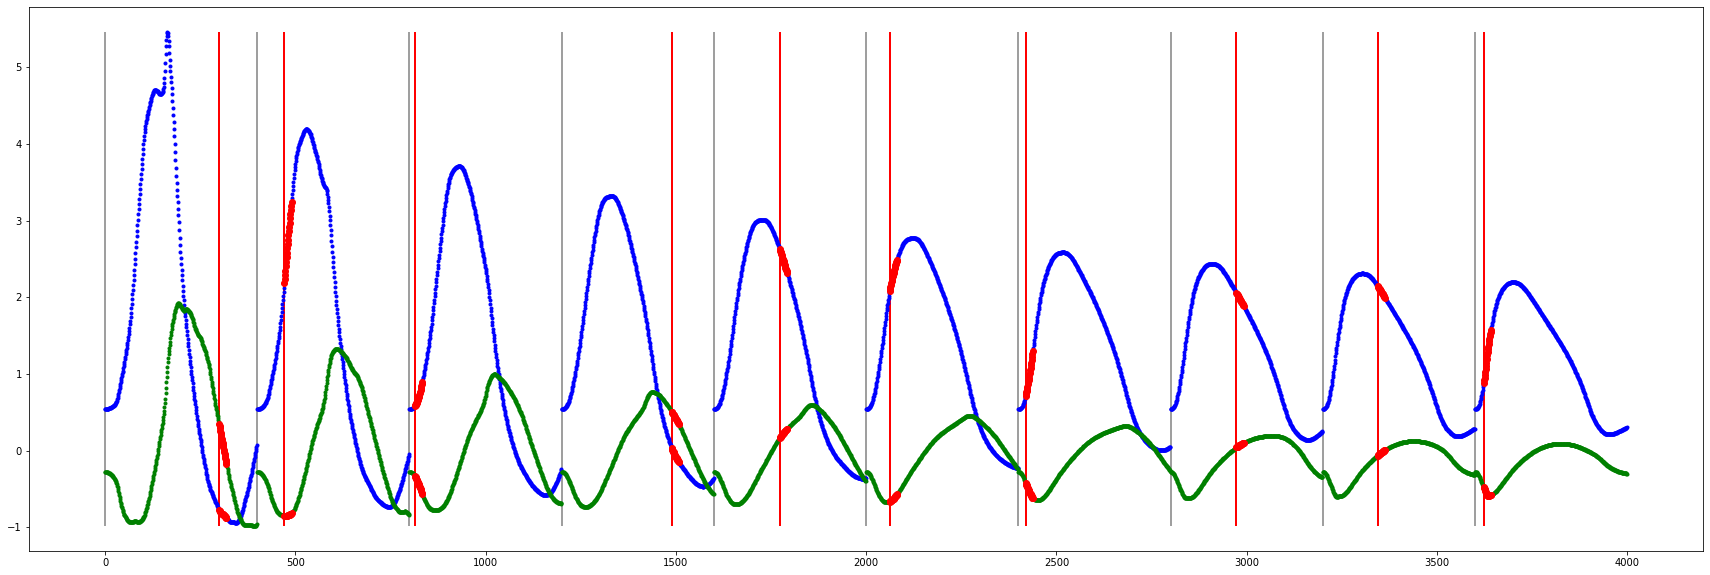

In [9]:
# VISUAL CHECK OF BATCHED DATA

with torch.no_grad():
    batch_u0, batch_u, batch_t, s = get_data(20)

    plt.figure(figsize=(30,10))
    plt.vlines(np.arange(0,train_len,block_size),train_set.min(),train_set.max(),color='gray')
    plt.vlines(s.cpu(),train_set.min(),train_set.max(),color='red',linewidth=2)
    plt.plot(train_set[:,:,0].cpu(),'.b')
    plt.plot(train_set[:,:,1].cpu(),'.g')
    for jj in range(n_params_train):
        plt.plot(s[jj].cpu()+batch_t.cpu(),batch_u[:,jj,:,0].cpu(),'or')
        plt.plot(s[jj].cpu()+batch_t.cpu(),batch_u[:,jj,:,1].cpu(),'or')

In [10]:
batch_u0.shape, batch_u.shape, batch_t.shape

(torch.Size([10, 1, 3]), torch.Size([20, 10, 1, 2]), torch.Size([20]))

In [11]:
class ODEfunc(nn.Module):
    def __init__(self,hidden_dim):
        super(ODEfunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(hidden_dim,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,hidden_dim),
        )
        
    def forward(self, t, y):
        return self.net(y)

In [12]:
class ODENet(nn.Module):
    def __init__(self, hidden_dim):
        super(ODENet, self).__init__()

        
        self.net1 = nn.Sequential(
            nn.Linear(3,32),
            nn.ELU(),
            nn.Linear(32,64),
            nn.ELU(),
            nn.Linear(64,hidden_dim)
        )

        self.ODEblock = ODEfunc(hidden_dim).to(device)

        self.net2 = nn.Sequential(
            nn.Linear(hidden_dim,64),
            nn.ELU(),
            nn.Linear(64,32),
            nn.ELU(),
            nn.Linear(32,2)
        )

        
    def forward(self, t, y):
        x = self.net1(y)
        x = odeint(self.ODEblock,x,t)
        x = self.net2(x)
        return x

In [13]:
model = ODENet(16).to(device)

In [14]:
def integrationtime_schedule(itr,maxinttime,mininttime,niters):
  return round(itr*(maxinttime-mininttime)/niters)+mininttime

In [15]:
lrate = 1e-3
niters = 9000
mininttime = 30
maxinttime = block_size

itr_time = []
loss_array = []

optimizer = optim.Adam(model.parameters(), lr=lrate)

for itr in range(1, niters + 1):

        int_time = integrationtime_schedule(itr,maxinttime,mininttime,niters)
        start_itr = time.time()
        batch_u0, batch_u, batch_t, _ = get_data(int_time)
        pred_u = model(batch_t,batch_u0)
        
        loss = torch.mean(torch.pow(pred_u - batch_u,2))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        itr_time.append(time.time()-start_itr)
        loss_array.append(loss.item())
        clear_output(wait=True)
        display('Iter ' + str(itr)+'/'+str(niters) + '  |  Loss: ' + str(round(loss.item(),6))+ ' | integr time: ' + str(int_time))

        if itr % freq == 0:
            with torch.no_grad():
                print('Iter ' + str(itr)+'/'+str(niters) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5))+' s' + '\t integr time: '+str(int_time))
                #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
                #       ii += 1


'Iter 9000/9000  |  Loss: 0.000384 | integr time: 400'

Iter 9000/9000	|  Loss: 0.000384	|  lr: 0.001	|  itr time: 1.77253 s	 integr time: 400


In [16]:
lrate = 1e-4
niters = 1000

itr_time = []
loss_array = []

optimizer = optim.Adam(model.parameters(), lr=lrate)

for itr in range(1, niters + 1):

        int_time = maxinttime
        start_itr = time.time()
        batch_u0, batch_u, batch_t, _ = get_data(int_time)
        pred_u = model(batch_t,batch_u0)
        
        loss = torch.mean(torch.pow(pred_u - batch_u,2))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        itr_time.append(time.time()-start_itr)
        loss_array.append(loss.item())
        clear_output(wait=True)
        display('Iter ' + str(itr)+'/'+str(niters) + '  |  Loss: ' + str(round(loss.item(),6))+ ' | integr time: ' + str(int_time))

        if itr % freq == 0:
            with torch.no_grad():
                print('Iter ' + str(itr)+'/'+str(niters) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5))+' s' + '\t integr time: '+str(int_time))
                #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
                #       ii += 1


'Iter 1000/1000  |  Loss: 5.6e-05 | integr time: 400'

Iter 1000/1000	|  Loss: 5.6e-05	|  lr: 0.0001	|  itr time: 1.72348 s	 integr time: 400


In [17]:
inttime_array = [integrationtime_schedule(itr,maxinttime,mininttime,niters) for itr in range(niters)]

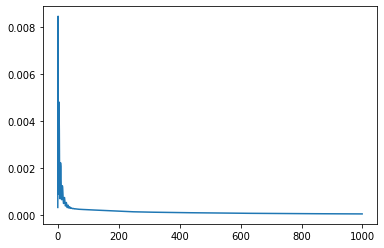

In [18]:
plt.plot(loss_array)

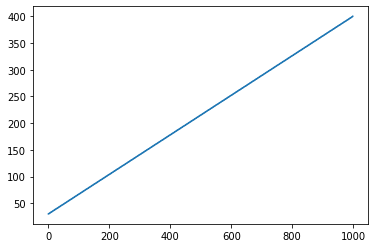

In [19]:
plt.plot(inttime_array)

In [20]:
pred_u.shape

torch.Size([400, 10, 1, 2])

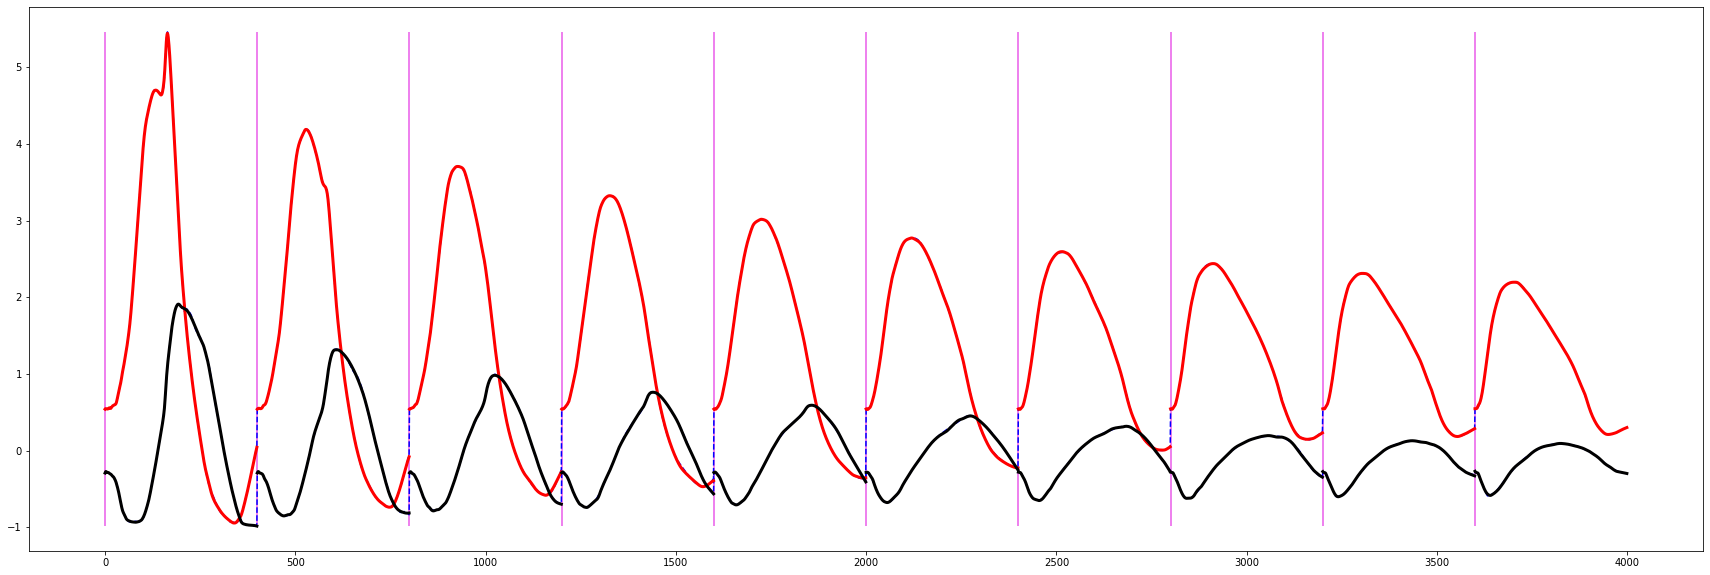

In [21]:
with torch.no_grad():
    batch_u0, batch_u, batch_t, s = get_data(400)
    pred_u = model(batch_t,batch_u0)

    plt.figure(figsize=(30,10))
    plt.vlines(np.arange(0,train_len,block_size),train_set.min(),train_set.max(),color='gray')
    plt.vlines(s.cpu(),train_set.min(),train_set.max(),color='violet',linewidth=2)
    plt.plot(train_set[:,:,0].cpu(),'--b')
    plt.plot(train_set[:,:,1].cpu(),'--b')
    for jj in range(n_params_train):
        #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,0],'or')
        #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,1],'or')
        plt.plot(s[jj].cpu()+batch_t.cpu(),pred_u[:,jj,:,0].cpu(),'-r',linewidth=3)
        plt.plot(s[jj].cpu()+batch_t.cpu(),pred_u[:,jj,:,1].cpu(),'-k',linewidth=3)

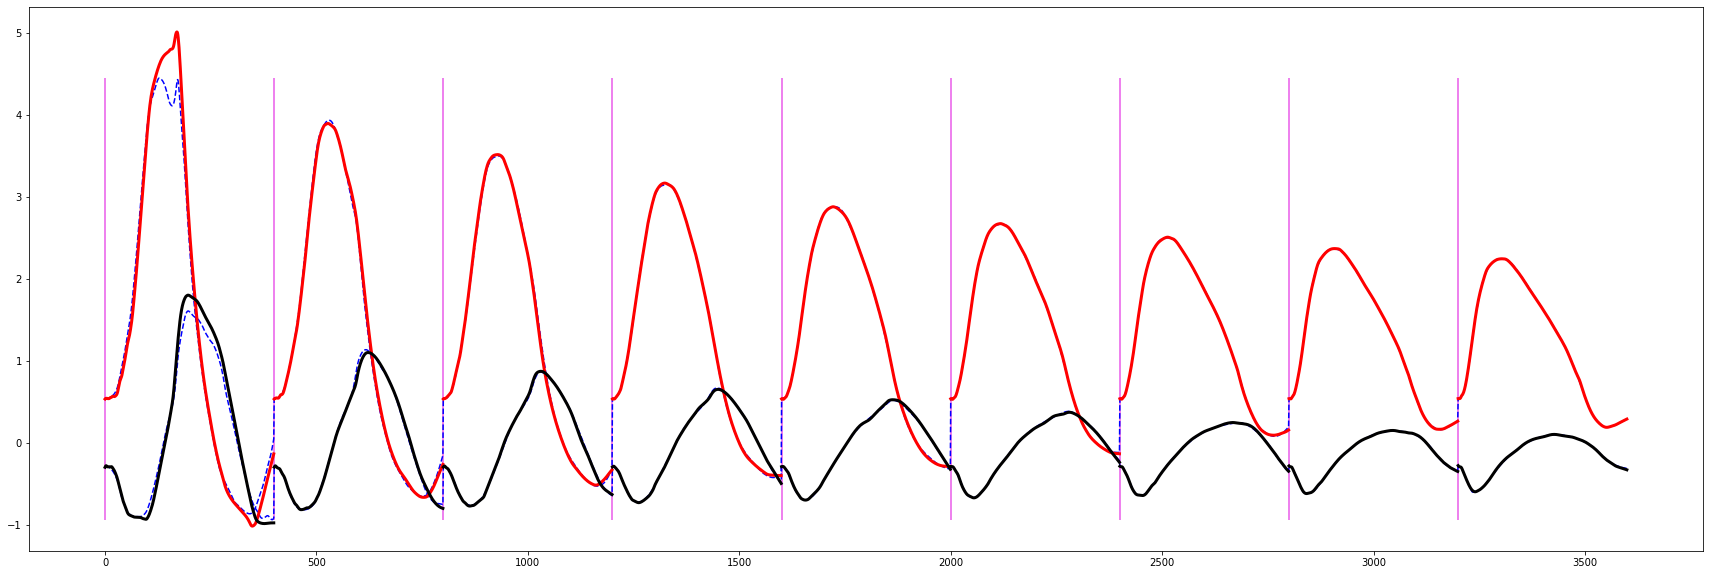

In [22]:
if True:
    with torch.no_grad():
        batch_u0, batch_u, batch_t, s = get_data(400,'test',True,400)
        pred_u_test = model(batch_t,batch_u0)

        plt.figure(figsize=(30,10))
        plt.vlines(np.arange(0,test_len,block_size),test_set.min(),test_set.max(),color='gray')
        plt.vlines(s.cpu(),test_set.min(),test_set.max(),color='violet',linewidth=2)
        plt.plot(test_set[:,:,0].cpu(),'--b')
        plt.plot(test_set[:,:,1].cpu(),'--b')
        for jj in range(n_params_test):
            #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,0],'or')
            #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,1],'or')
            plt.plot(s[jj].cpu()+batch_t.cpu(),pred_u_test[:,jj,:,0].cpu(),'-r',linewidth=3)
            plt.plot(s[jj].cpu()+batch_t.cpu(),pred_u_test[:,jj,:,1].cpu(),'-k',linewidth=3)

In [23]:
pred_u_test_ = torch.cat([pred_u_test[:,i,:,:] for i in range(n_params_test)]).squeeze(1)
pred_u_test_dic = {'S': pred_u_test_.cpu().detach().numpy()}
scipy.io.savemat("predictions_Ntrain10.mat", pred_u_test_dic)

In [24]:
torch.save(model.state_dict(), 'node_Ntrain10_statedict.pt')